# Exercise Chapter 8 
Modern Statistics: A Computer Based Approach with Python<br>
by Ron Kenett, Shelemyahu Zacks, Peter Gedeck

Publisher: Springer International Publishing; 1st edition (September 15, 2022) <br>
ISBN-13: 978-3031075650

(c) 2022 Ron Kenett, Shelemyahu Zacks, Peter Gedeck

The code needs to be executed in sequence.

Python packages and Python itself change over time. This can cause warnings or errors. We
"Warnings" are for information only and can usually be ignored. 
"Errors" will stop execution and need to be fixed in order to get results. 

If you come across an issue with the code, please follow these steps

- Check the repository (https://gedeck.github.io/mistat-code-solutions/) to see if the code has been upgraded. This might solve the problem.
- Check the errata at (https://gedeck.github.io/mistat-code-solutions/ModernStatistics/) and the issue tracker at https://github.com/gedeck/mistat-code-solutions/issues to see if the issue is known and a solution available.
- Report the problem using the issue tracker at https://github.com/gedeck/mistat-code-solutions/issues
- Paste the error message into Google and see if someone else already found a solution

In [1]:
import warnings
import os
os.environ['OUTDATED_IGNORE'] = '1'
from outdated import OutdatedPackageWarning
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=OutdatedPackageWarning)

In [2]:
import mistat
import networkx as nx
from pgmpy.estimators import HillClimbSearch
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# Exercise 1

In [3]:
from skfda import FDataGrid
from skfda.representation.interpolation import SplineInterpolation

dissolution = mistat.load_data('DISSOLUTION.csv')

# convert the data to FDataGrid
data = []
labels = []
names = []
for label, group in dissolution.groupby('Label'):
  data.append(group['Data'].values)
  labels.append('Reference' if label.endswith('R') else 'Test')
  names.append(label)
labels = np.array(labels)
grid_points = np.array(sorted(dissolution['Time'].unique()))
fd = FDataGrid(np.array(data), grid_points,
       dataset_name='Dissolution',
       argument_names=['Time'],
       coordinate_names=['Dissolution'])

In [4]:
from skfda.preprocessing.registration import ShiftRegistration
shift_registration = ShiftRegistration()

fd_registered = {}
for order in (1, 2, 3):
    fd.interpolation = SplineInterpolation(interpolation_order=order)
    fd_registered[order] = shift_registration.fit_transform(fd)

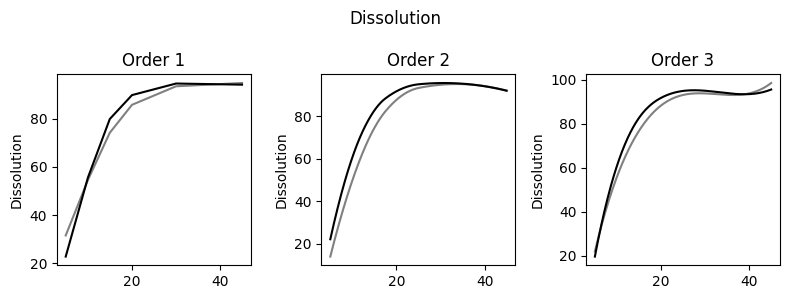

In [5]:
from skfda.exploratory import stats

group_colors = {'Reference': 'grey', 'Test': 'black'}

fig, axes = plt.subplots(ncols=3, figsize=(8, 3))
for ax, order in zip(axes, (1, 2, 3)):
    mean_ref = stats.mean(fd_registered[order][labels=='Reference'])
    mean_test = stats.mean(fd_registered[order][labels=='Test'])
    means = mean_ref.concatenate(mean_test)
    means.plot(axes=[ax], group=['Reference', 'Test'], group_colors=group_colors)
    ax.set_title(f'Order {order}')
plt.tight_layout()

# Exercise 2

In [6]:
import skfda
from skfda import FDataGrid

pinchraw = skfda.datasets.fetch_cran('pinchraw', 'fda')['pinchraw']
pinchtime = skfda.datasets.fetch_cran('pinch', 'fda')['pinchtime']

fd = FDataGrid(pinchraw.transpose(), pinchtime)

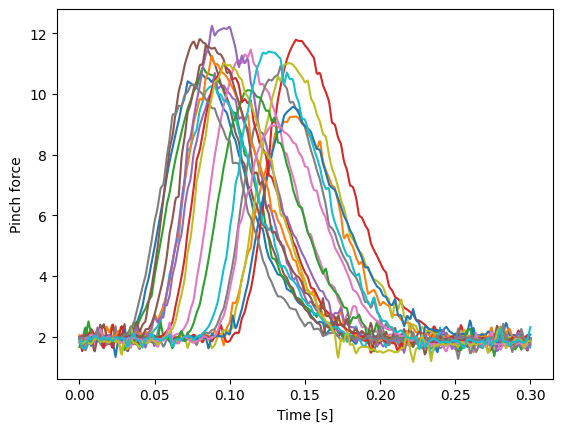

In [7]:
fig = fd.plot()
ax = fig.axes[0]
ax.set_xlabel('Time [s]')
ax.set_ylabel('Pinch force')
plt.show()

/tmp/ipykernel_544/3664379094.py:2: DeprecationWarning: The "kernel_smoothers" module is deprecated. Use the "KernelSmoother" class instead
  from skfda.preprocessing.smoothing.kernel_smoothers import NadarayaWatsonSmoother


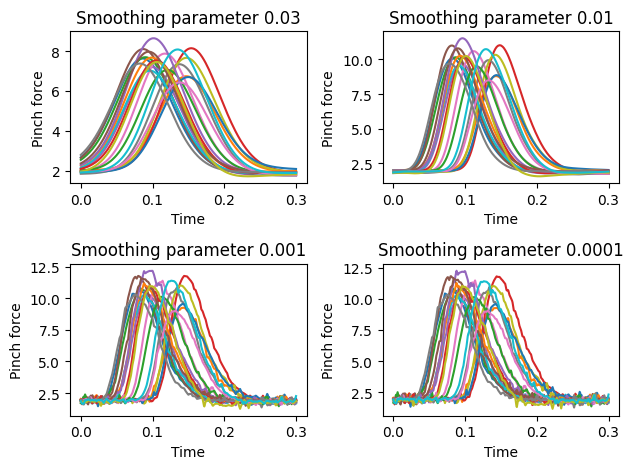

In [8]:
import itertools
from skfda.preprocessing.smoothing.kernel_smoothers import NadarayaWatsonSmoother

def plotSmoothData(fd, smoothing_parameter, ax):
    smoother = NadarayaWatsonSmoother(smoothing_parameter=smoothing_parameter)
    fd_smooth = smoother.fit_transform(fd)
    _ = fd_smooth.plot(axes=[ax])
    ax.set_title(f'Smoothing parameter {smoothing_parameter}')
    ax.set_xlabel('Time')
    ax.set_ylabel('Pinch force')

fig, axes = plt.subplots(ncols=2, nrows=2)
axes = list(itertools.chain(*axes))  # flatten list of lists
for i, sp in enumerate([0.03, 0.01, 0.001, 0.0001]):
    plotSmoothData(fd, sp, axes[i])
plt.tight_layout()

In [9]:
smoother = NadarayaWatsonSmoother(smoothing_parameter=0.005)
fd_smooth = smoother.fit_transform(fd)

In [10]:
max_idx = fd_smooth.data_matrix.argmax(axis=1)
landmarks = [pinchtime[idx] for idx in max_idx]

In [11]:
from skfda.preprocessing.registration import landmark_shift
fd_landmark = landmark_shift(fd_smooth, landmarks)

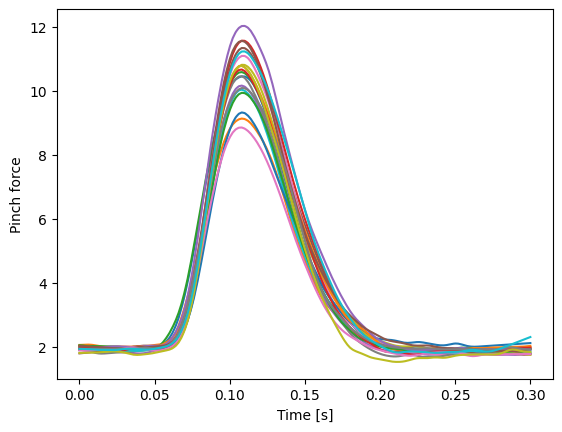

In [12]:
fig = fd_landmark.plot()
ax = fig.axes[0]
ax.set_xlabel('Time [s]')
ax.set_ylabel('Pinch force')
plt.show()

# Exercise 3

In [13]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

In [14]:
import skfda

moisturespectrum = skfda.datasets.fetch_cran('Moisturespectrum', 'fds')
moisturevalues = skfda.datasets.fetch_cran('Moisturevalues', 'fds')

frequencies = moisturespectrum['Moisturespectrum']['x']
spectra = moisturespectrum['Moisturespectrum']['y']
moisture = moisturevalues['Moisturevalues']

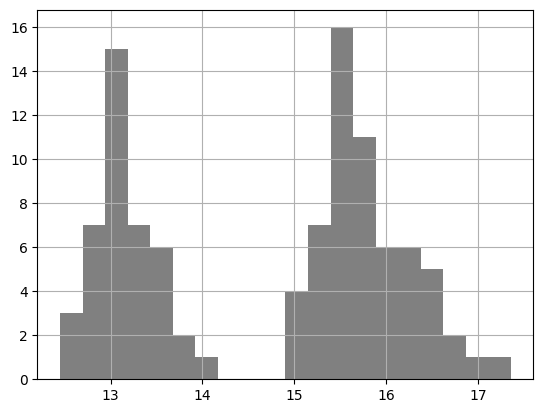

In [15]:
_ = pd.Series(moisture).hist(bins=20, color='grey', label='Moisture content')

In [16]:
moisture_class = ['high' if m > 14.5 else 'low' for m in moisture]

In [17]:
intensities = spectra.transpose()
fd = skfda.FDataGrid(intensities, frequencies)

# divide each sample spectrum by it's mean intensities
intensities_normalized = (intensities - intensities.mean(dim='dim_0')) / intensities.std(dim='dim_0')
fd_normalized = skfda.FDataGrid(intensities_normalized, frequencies)

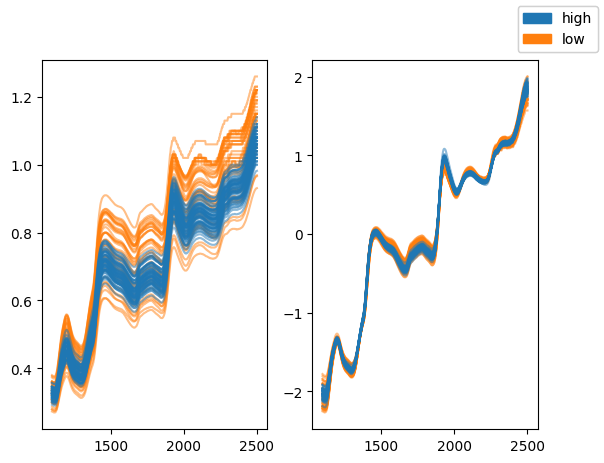

In [18]:
fig, axes = plt.subplots(ncols=2)
_ = fd.plot(axes=axes[0], alpha=0.5,
            # color lines by moisture class
            group=moisture_class, group_names={'high': 'high', 'low': 'low'})
_ = fd_normalized.plot(axes=axes[1], alpha=0.5,
            group=moisture_class, group_names={'high': 'high', 'low': 'low'})

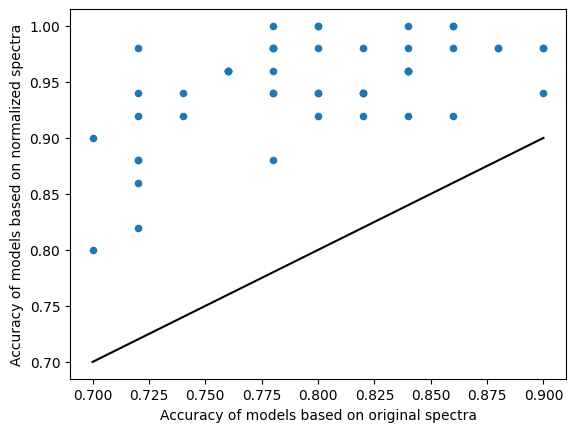

original      0.7976
normalized    0.9468
dtype: float64

In [19]:
from skfda.ml.classification import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

accuracies = []
for rs in range(50):
    X_train, X_test, y_train, y_test = train_test_split(fd,
        moisture_class, random_state=rs, test_size=0.5)
    knn_original = KNeighborsClassifier()
    knn_original.fit(X_train, y_train)
    acc_original = accuracy_score(y_test, knn_original.predict(X_test))

    X_train, X_test, y_train, y_test = train_test_split(fd_normalized,
        moisture_class, random_state=rs, test_size=0.5)
    knn_normalized = KNeighborsClassifier()
    knn_normalized.fit(X_train, y_train)
    acc_normalized = accuracy_score(y_test, knn_normalized.predict(X_test))
    accuracies.append({
        'original': acc_original,
        'normalized': acc_normalized,
    })
accuracies = pd.DataFrame(accuracies)
ax  = accuracies.plot.scatter(x='original', y='normalized')
_ = ax.plot([0.7, 0.9], [0.7, 0.9], color='black')
ax.set_xlabel('Accuracy of models based on original spectra')
ax.set_ylabel('Accuracy of models based on normalized spectra')
plt.show()

# mean of accuracies
mean_accuracy = accuracies.mean()
mean_accuracy

# Exercise 4

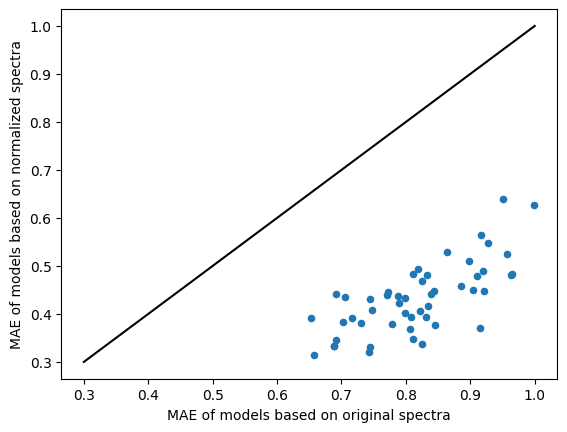

original      0.817016
normalized    0.433026
dtype: float64

In [20]:
from skfda.ml.regression import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

mae = []
for rs in range(50):
    X_train, X_test, y_train, y_test = train_test_split(fd,
        moisture, random_state=rs, test_size=0.5)
    knn_original = KNeighborsRegressor()
    knn_original.fit(X_train, y_train)
    mae_original = mean_absolute_error(y_test, knn_original.predict(X_test))

    X_train, X_test, y_train, y_test = train_test_split(fd_normalized,
        moisture, random_state=rs, test_size=0.5)
    knn_normalized = KNeighborsRegressor()
    knn_normalized.fit(X_train, y_train)
    mae_normalized = mean_absolute_error(y_test, knn_normalized.predict(X_test))
    mae.append({
        'original': mae_original,
        'normalized': mae_normalized,
    })
mae = pd.DataFrame(mae)
ax  = mae.plot.scatter(x='original', y='normalized')
ax.plot([0.3, 1.0], [0.3, 1.0], color='black')
ax.set_xlabel('MAE of models based on original spectra')
ax.set_ylabel('MAE of models based on normalized spectra')
plt.show()

# mean of MAE
mean_mae = mae.mean()
mean_mae

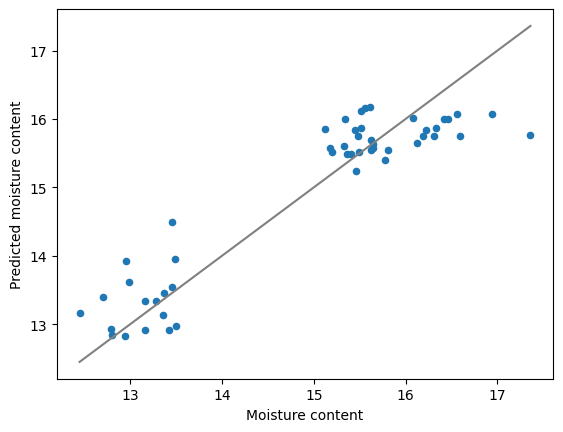

In [21]:
y_pred = knn_normalized.predict(X_test)
predictions = pd.DataFrame({'actual': y_test, 'predicted': y_pred})
minmax = [min(*y_test, *y_pred), max(*y_test, *y_pred)]

ax = predictions.plot.scatter(x='actual', y='predicted')
ax.set_xlabel('Moisture content')
ax.set_ylabel('Predicted moisture content')
ax.plot(minmax, minmax, color='grey')
plt.show()

# Exercise 5

In [22]:
from skfda.preprocessing.dim_reduction import FPCA

fpca_original = FPCA(n_components=2)
_ = fpca_original.fit(fd)

fpca_normalized = FPCA(n_components=2)
_ = fpca_normalized.fit(fd_normalized)

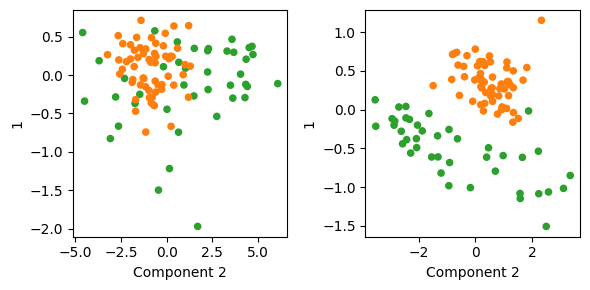

In [23]:
def plotFPCA(fpca, fd, ax):
  fpca_df = pd.DataFrame(fpca.transform(fd))
  fpca_df.plot.scatter(x=0, y=1,
      c=['C1' if mc == 'high' else 'C2' for mc in moisture_class], ax=ax)
  ax.set_xlabel('Component 1')
  ax.set_xlabel('Component 2')

fig, axes = plt.subplots(ncols=2, figsize=[6, 3])
plotFPCA(fpca_original, fd, axes[0])
plotFPCA(fpca_normalized, fd_normalized, axes[1])
plt.tight_layout()

# Exercise 6

In [24]:
from mistat.nlp import globalWarmingBlogs
blogs = globalWarmingBlogs()

In [25]:
paragraphs = []
labels = []
for blog, text in blogs.items():
  for paragraph in text.split('\n'):
    paragraph = paragraph.strip()
    if not paragraph: # ignore empty paragraphs
      continue
    paragraphs.append(paragraph)
    labels.append(blog)

In [26]:
import re
from sklearn.feature_extraction.text import CountVectorizer

def preprocessor(text):
    text = text.lower()
    text = re.sub(r'\d[\d,]*', '', text)
    text = '\n'.join(line for line in text.split('\n')
                     if not line.startswith('ntsb'))
    return text

vectorizer = CountVectorizer(preprocessor=preprocessor,
                             stop_words='english')
counts = vectorizer.fit_transform(paragraphs)

print('shape of DTM', counts.shape)
print('total number of terms', np.sum(counts))

shape of DTM (123, 1025)
total number of terms 2946


In [27]:
termCounts = np.array(counts.sum(axis=0)).flatten()
topCounts = termCounts.argsort()
terms = vectorizer.get_feature_names_out()
for n in reversed(topCounts[-10:]):
  print(f'{terms[n]:14s}  {termCounts[n]:3d}')

global           63
climate          59
warming          57
change           55
ice              35
sea              34
earth            33
ocean            29
temperatures     28
heat             25


In [28]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidfTransformer = TfidfTransformer(smooth_idf=False, norm=None)
tfidf = tfidfTransformer.fit_transform(counts)

In [29]:
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
svd = TruncatedSVD(5)
norm_tfidf = Normalizer().fit_transform(tfidf)
lsa_tfidf = svd.fit_transform(norm_tfidf)

In [30]:
terms = vectorizer.get_feature_names_out()
data = {}
for i, component in enumerate(svd.components_, 1):
  compSort = component.argsort()
  idx = list(reversed(compSort[-10:]))
  data[f'Topic {i}'] = [terms[n] for n in idx]
  data[f'Loading {i}'] = [component[n] for n in idx]
df = pd.DataFrame(data)

In [31]:
df

,Topic 1,Loading 1,Topic 2,Loading 2,Topic 3,Loading 3,Topic 4,Loading 4,Topic 5,Loading 5
0,change,0.238472,ice,0.390428,extreme,0.340350,extreme,0.537639,snow,0.398045
1,climate,0.237831,sea,0.345344,change,0.232952,events,0.309419,cover,0.237511
2,global,0.234040,sheets,0.272853,climate,0.221081,heat,0.229299,sea,0.163191
3,sea,0.219131,shrinking,0.194124,events,0.201330,precipitation,0.202067,temperatures,0.123599
4,warming,0.210643,level,0.169022,precipitation,0.117285,light,0.130257,climate,0.120088
5,ice,0.198531,arctic,0.149834,number,0.080616,earth,0.124035,hurricanes,0.114910
6,temperature,0.175046,ocean,0.125586,issues,0.076756,energy,0.122681,level,0.114256
7,ocean,0.164640,declining,0.101460,presence,0.074482,gases,0.117285,decreased,0.113618
8,earth,0.156264,levels,0.081131,wildfires,0.074236,greenhouse,0.107229,increase,0.099009
9,extreme,0.149380,glaciers,0.074209,warming,0.071728,infrared,0.107175,temperature,0.097989


In [32]:
svd = TruncatedSVD(10)
norm_tfidf = Normalizer().fit_transform(tfidf)
lsa_tfidf = svd.fit_transform(norm_tfidf)

In [33]:
terms = vectorizer.get_feature_names_out()
data = {}
for i, component in enumerate(svd.components_, 1):
  compSort = component.argsort()
  idx = list(reversed(compSort[-10:]))
  data[f'Topic {i}'] = [terms[n] for n in idx]
  data[f'Loading {i}'] = [component[n] for n in idx]
df = pd.DataFrame(data)

In [34]:
df

,Topic 1,Loading 1,Topic 2,Loading 2,Topic 3,Loading 3,Topic 4,Loading 4,Topic 5,Loading 5,Topic 6,Loading 6,Topic 7,Loading 7,Topic 8,Loading 8,Topic 9,Loading 9,Topic 10,Loading 10
0,change,0.238541,ice,0.390572,extreme,0.339710,extreme,0.536368,snow,0.401830,sea,0.378749,snow,0.343752,ocean,0.413859,glaciers,0.371903,hurricanes,0.271767
1,climate,0.237903,sea,0.345465,change,0.230389,events,0.309139,cover,0.241635,level,0.358861,ocean,0.250839,acidification,0.203853,water,0.230853,ocean,0.168211
2,global,0.233996,sheets,0.272731,climate,0.219538,heat,0.230509,sea,0.167151,rise,0.167220,cover,0.242571,hurricanes,0.174645,retreat,0.228577,events,0.138802
3,sea,0.219123,shrinking,0.193970,events,0.198851,precipitation,0.202802,climate,0.122154,extreme,0.138036,extreme,0.180069,water,0.152214,glacial,0.195942,org,0.137037
4,warming,0.210561,level,0.169197,precipitation,0.116072,light,0.128406,decreased,0.118356,hurricanes,0.119041,acidification,0.165022,waters,0.131157,months,0.162933,howglobalwarmingworks,0.137037
5,ice,0.198552,arctic,0.150504,number,0.080705,earth,0.125640,temperatures,0.118327,global,0.113944,decreased,0.124137,temperatures,0.120448,summer,0.141478,know,0.134705
6,temperature,0.175086,ocean,0.126289,issues,0.075386,energy,0.119612,level,0.118088,events,0.107683,carbon,0.123299,glaciers,0.114861,plants,0.130279,energy,0.128851
7,ocean,0.164627,declining,0.101788,presence,0.072876,gases,0.115728,hurricanes,0.116855,temperature,0.093763,point,0.117782,marine,0.099358,going,0.116028,video,0.128606
8,earth,0.156243,levels,0.080283,warming,0.070979,infrared,0.105558,increase,0.103118,impacts,0.092884,level,0.114689,reduce,0.099192,animals,0.112569,light,0.119466
9,extreme,0.149376,glaciers,0.073399,wildfires,0.068473,greenhouse,0.105481,rise,0.095460,coastal,0.076867,warming,0.103120,warmer,0.092150,stream,0.110257,ok,0.109747


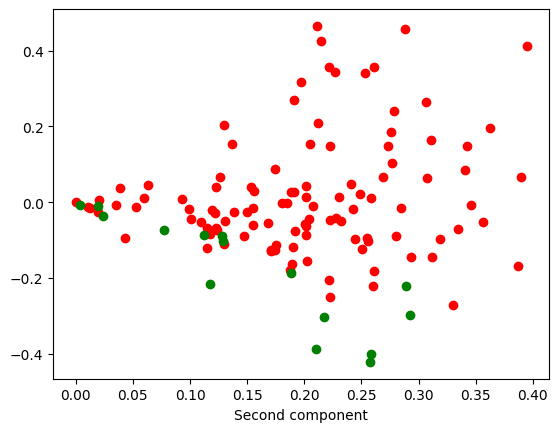

In [35]:
fig, ax = plt.subplots()
blog1 = [label == 'blog-1' for label in labels]
blog2 = [label == 'blog-2' for label in labels]
ax.plot(lsa_tfidf[blog1, 0], lsa_tfidf[blog1, 1], 'ro')
ax.plot(lsa_tfidf[blog2, 0], lsa_tfidf[blog2, 1], 'go')
ax.set_xlabel('First component')
ax.set_xlabel('Second component')
plt.show()

# Exercise 7

In [36]:
from mistat.nlp import covid19Blogs
blogs = covid19Blogs()

In [37]:
paragraphs = []
labels = []
for blog, text in blogs.items():
  for paragraph in text.split('\n'):
    paragraph = paragraph.strip()
    if not paragraph:
      continue
    paragraphs.append(paragraph)
    labels.append(blog)

def preprocessor(text):
  text = text.lower()
  text = re.sub(r'\d[\d,]*', '', text)
  text = '\n'.join(line for line in text.split('\n')
                   if not line.startswith('ntsb'))
  return text

vectorizer = CountVectorizer(preprocessor=preprocessor, stop_words='english')
counts = vectorizer.fit_transform(paragraphs)

In [38]:
tfidfTransformer = TfidfTransformer(smooth_idf=False, norm=None)
tfidf = tfidfTransformer.fit_transform(counts)

In [39]:
svd = TruncatedSVD(10)
tfidf = Normalizer().fit_transform(tfidf)
lsa_tfidf = svd.fit_transform(tfidf)

In [40]:
terms = vectorizer.get_feature_names_out()
data = {}
for i, component in enumerate(svd.components_, 1):
  compSort = component.argsort()
  idx = list(reversed(compSort[-10:]))
  data[f'Topic {i}'] = [terms[n] for n in idx]
  data[f'Loading {i}'] = [component[n] for n in idx]
df = pd.DataFrame(data)

In [41]:
df

,Topic 1,Loading 1,Topic 2,Loading 2,Topic 3,Loading 3,Topic 4,Loading 4,Topic 5,Loading 5,Topic 6,Loading 6,Topic 7,Loading 7,Topic 8,Loading 8,Topic 9,Loading 9,Topic 10,Loading 10
0,labour,0.286565,labour,0.275701,economic,0.235249,capacity,0.220620,economic,0.293226,america,0.267263,covid,0.209617,self,0.243403,needs,0.186391,agenda,0.183144
1,covid,0.218115,south,0.273467,percent,0.231025,financial,0.189851,social,0.229122,latin,0.253987,occupations,0.196558,employed,0.212748,world,0.147163,occupational,0.170175
2,impact,0.193743,north,0.216649,covid,0.179340,firms,0.188729,covid,0.217177,reset,0.122054,economic,0.182571,unbearable,0.205479,reset,0.142288,post,0.169779
3,market,0.188283,differences,0.194369,gdp,0.172057,household,0.175736,consequences,0.144486,needs,0.107096,asymmetric,0.173689,lightness,0.205479,covid,0.132834,channel,0.168790
4,south,0.181670,americas,0.170758,impact,0.143808,international,0.164452,asymmetric,0.141878,region,0.103046,consequences,0.172894,social,0.131744,need,0.124009,occupation,0.165123
5,america,0.160805,channel,0.159962,imf,0.134125,state,0.143797,region,0.121779,represent,0.094182,differences,0.135803,economic,0.130866,adapt,0.101047,employment,0.129086
6,pandemic,0.151379,agenda,0.138782,social,0.121006,largely,0.134605,recovery,0.103874,lac,0.088532,occupation,0.132139,financial,0.120981,formal,0.101047,capacity,0.124319
7,channel,0.151005,covid,0.125186,pre,0.113244,depends,0.134605,preservation,0.101159,argentina,0.085780,north,0.125558,employment,0.103388,private,0.101047,state,0.116722
8,economic,0.140886,post,0.104721,world,0.103393,access,0.129037,impact,0.099171,persistent,0.084928,represent,0.118065,countries,0.096996,training,0.099299,national,0.104509
9,north,0.136916,welfare,0.094173,growth,0.102804,support,0.127221,labor,0.097688,compared,0.082720,employment,0.116082,argentina,0.095356,policies,0.097738,labour,0.099657


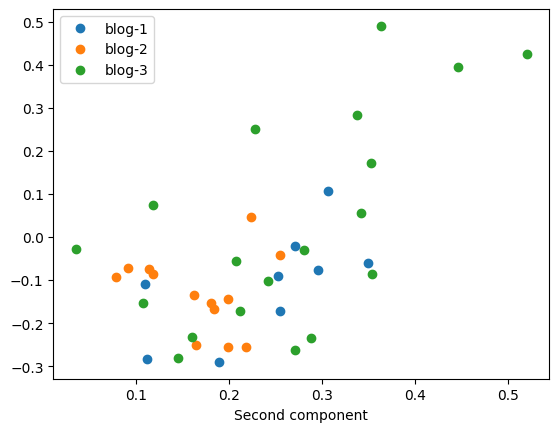

In [42]:
fig, ax = plt.subplots()
for blog in blogs:
    match = [label == blog for label in labels]
    ax.plot(lsa_tfidf[match, 0], lsa_tfidf[match, 1], 'o', label=blog)
ax.legend()
ax.set_xlabel('First component')
ax.set_xlabel('Second component')
plt.show()

# Exercise 8

In [43]:
data = mistat.load_data('LAPTOP_REVIEWS')
data['Review'] = data['Review title'] + ' ' + data['Review content']
reviews = data.dropna(subset=['User rating', 'Review title', 'Review content'])

In [44]:
import re
from sklearn.feature_extraction.text import CountVectorizer
def preprocessor(text):
    text = text.lower()
    text = re.sub(r'\d[\d,]*', '', text)
    return text

vectorizer = CountVectorizer(preprocessor=preprocessor,
                             stop_words='english')
counts = vectorizer.fit_transform(reviews['Review'])
print('shape of DTM', counts.shape)
print('total number of terms', np.sum(counts))

shape of DTM (7433, 12823)
total number of terms 251566


In [45]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidfTransformer = TfidfTransformer(smooth_idf=False, norm=None)
tfidf = tfidfTransformer.fit_transform(counts)

In [46]:
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
svd = TruncatedSVD(20)
tfidf = Normalizer().fit_transform(tfidf)
lsa_tfidf = svd.fit_transform(tfidf)
print(lsa_tfidf.shape)

(7433, 20)


In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

outcome = ['positive' if rating == 5 else 'negative'
           for rating in reviews['User rating']]

# split dataset into 60% training and 40% test set
Xtrain, Xtest, ytrain, ytest = train_test_split(lsa_tfidf, outcome,
                                                test_size=0.4, random_state=1)

# run logistic regression model on training
logit_reg = LogisticRegression(solver='lbfgs')
logit_reg.fit(Xtrain, ytrain)

# print confusion matrix and accuracty
accuracy = accuracy_score(ytest, logit_reg.predict(Xtest))
print(accuracy)
confusion_matrix(ytest, logit_reg.predict(Xtest))

0.7686617350369872


array([[ 861,  385],
       [ 303, 1425]])